In [1]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 4
NUM_FOOD = 30

class Arena:
    def __init__(self, size=10, num_food=20):
        self.size = size
        self.grid_columns = ["food"]
        self.grid = [[[0] for _ in range(size)] for _ in range(size)]  # Each cell holds food count
        
        self.num_food = num_food
        self._place_food()

    def _place_food(self):
        for _ in range(self.num_food):
            x = random.randint(0, self.size - 1)
            y = random.randint(0, self.size - 1)
            self.grid[x][y][0] += 1

    def display(self):
        df = pd.DataFrame(self.grid)
        print(df)
    
    def get_flat_grid(self):
        # make each cell into dict with the self.grid_columns as keys
        flat_grid = []
        for i in range(self.size):
            for j in range(self.size):
                cell = {self.grid_columns[k]: self.grid[i][j][k] for k in range(len(self.grid_columns))}
                
                # Add x and y
                cell["x"] = i
                cell["y"] = j

                flat_grid.append(cell)
        return flat_grid

arena = Arena(size=SIZE, num_food=NUM_FOOD)
arena.get_flat_grid()

[{'food': 0, 'x': 0, 'y': 0},
 {'food': 2, 'x': 0, 'y': 1},
 {'food': 2, 'x': 0, 'y': 2},
 {'food': 1, 'x': 0, 'y': 3},
 {'food': 2, 'x': 1, 'y': 0},
 {'food': 2, 'x': 1, 'y': 1},
 {'food': 2, 'x': 1, 'y': 2},
 {'food': 3, 'x': 1, 'y': 3},
 {'food': 2, 'x': 2, 'y': 0},
 {'food': 4, 'x': 2, 'y': 1},
 {'food': 1, 'x': 2, 'y': 2},
 {'food': 4, 'x': 2, 'y': 3},
 {'food': 1, 'x': 3, 'y': 0},
 {'food': 0, 'x': 3, 'y': 1},
 {'food': 3, 'x': 3, 'y': 2},
 {'food': 1, 'x': 3, 'y': 3}]

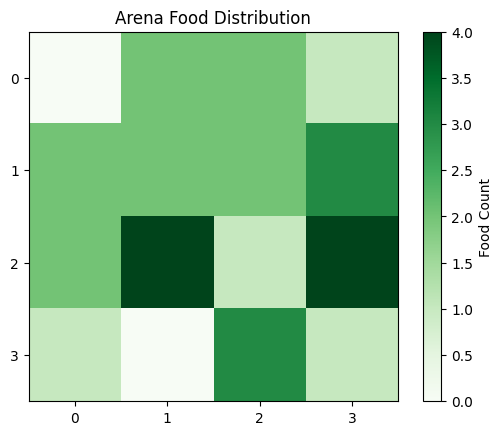

In [3]:
# plot as a grid with food in each
def plot_arena(arena):
    grid = np.zeros((arena.size, arena.size))
    for i in range(arena.size):
        for j in range(arena.size):
            grid[i][j] = arena.grid[i][j][0]
    
    plt.imshow(grid, cmap='Greens', interpolation='nearest')
    plt.colorbar(label='Food Count')
    plt.title('Arena Food Distribution')
    plt.xticks(range(arena.size), range(arena.size))
    plt.yticks(range(arena.size), range(arena.size))
    plt.show()
plot_arena(arena)

In [5]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

class Simulation:
    def __init__(self, grid_size=4, num_agents=10, num_food=30, cycles=100, types=None):
        self.grid_size = grid_size
        self.num_food = num_food
        self.cycles = cycles
        self.cycle_idx = 0
        self.types = types
        
        # If types are provided, use them to create the initial agents.
        # types is expected to be a list of lists, e.g. [['A', 10], ['B', 5]]
        if self.types is not None:
            self.num_agents = sum([count for _, count in self.types])
        else:
            # If not provided, default to one type 'A' for all agents.
            self.types = [['A', num_agents]]
            self.num_agents = num_agents
        
        # Create initial agents with an additional 'type' column.
        agents_list = []
        agent_id = 0
        for agent_type, count in self.types:
            for _ in range(count):
                agents_list.append({
                    'id': agent_id,
                    'x': np.nan,
                    'y': np.nan,
                    'food': 0,
                    'status': 'alive',
                    'type': agent_type
                })
                agent_id += 1
        
        self.agents = pd.DataFrame(agents_list)
        
        # Prepare the simulation summary DataFrame with additional columns for each type.
        type_columns = [agent_type for agent_type, _ in self.types]
        self.sim_summary = pd.DataFrame(columns=['cycle', 'agents', 'new_agents'] + type_columns, index=range(cycles))

    def run_next_cycle(self, score_function: callable):
        arena = Arena(size=self.grid_size, num_food=self.num_food)
        flat_grid = arena.get_flat_grid()

        #### CHOOSE CELL ####
        # Each agent chooses a cell based on the score function.
        for idx, agent in self.agents.iterrows():
            scores = [score_function(cell, agent) for cell in flat_grid]
            top_score_idx = np.argmax(scores)
            best_cell = flat_grid[top_score_idx]
            self.agents.loc[idx, 'x'] = best_cell['x']
            self.agents.loc[idx, 'y'] = best_cell['y']

        #### ALLOCATE FOOD ####
        # Build a mapping of (x, y) -> food count from the flat grid.
        food_map = {(cell["x"], cell["y"]): cell["food"] for cell in flat_grid if cell["food"] > 0}
        for (x, y), food_count in food_map.items():
            # Find agents on this cell.
            agents_on_cell = self.agents[(self.agents['x'] == x) & (self.agents['y'] == y)]
            if agents_on_cell.empty:
                continue
            # Shuffle agents randomly.
            shuffled_agents = agents_on_cell.sample(frac=1.0, random_state=random.randint(0, 99999))
            # Allocate food one-by-one.
            loops = min(2 * len(agents_on_cell), food_count)
            for _ in range(loops):
                for idx, agent in shuffled_agents.iterrows():
                    if food_count == 0:
                        break
                    self.agents.loc[idx, 'food'] += 1
                    food_count -= 1

        #### AGENT DECISION ####
        # Agent decisions:
        # - If an agent has 0 food, it dies.
        # - If an agent has 2 or more food, it replicates (parent's food becomes 1 and a new copy is created with food = 1).
        # - Otherwise (if food == 1), the agent survives and its food decreases by 1.
        REP_FOOD = 3

        new_agents = []
        for idx, agent in self.agents.iterrows():
            if agent['food'] == 0:
                self.agents.loc[idx, 'status'] = 'dead'
            elif agent['food'] >= REP_FOOD:
                new_agent = agent.copy()  # New agent inherits the parent's type.
                new_agent['food'] = 1
                new_agents.append(new_agent)
                self.agents.loc[idx, 'food'] = 1
                self.agents.loc[idx, 'status'] = 'alive'
            else:
                self.agents.loc[idx, 'food'] -= 1
                self.agents.loc[idx, 'status'] = 'alive'

        new_agents = pd.DataFrame(new_agents)
        new_agents['id'] = range(self.agents['id'].max() + 1,
                                  self.agents['id'].max() + 1 + len(new_agents))

        #### SIMULATION SUMMARY ####
        # Remove dead agents.
        self.agents = self.agents[self.agents['status'] == 'alive']
        # Count agents by type.
        type_counts = self.agents['type'].value_counts().to_dict()
        # Ensure every type is represented in the counts.
        for agent_type, _ in self.types:
            if agent_type not in type_counts:
                type_counts[agent_type] = 0

        self.sim_summary.loc[self.cycle_idx, 'cycle'] = self.cycle_idx
        self.sim_summary.loc[self.cycle_idx, 'agents'] = len(self.agents)
        self.sim_summary.loc[self.cycle_idx, 'new_agents'] = len(new_agents)
        for agent_type, _ in self.types:
            self.sim_summary.loc[self.cycle_idx, agent_type] = type_counts.get(agent_type, 0)

        #### RESET AGENTS ####
        # Merge surviving agents with new agents and reset their state.
        self.agents = pd.concat([self.agents, new_agents], ignore_index=True)
        self.agents["x"] = np.nan
        self.agents["y"] = np.nan
        self.agents["food"] = 0
        self.agents["status"] = 'alive'

        self.cycle_idx += 1

    def run(self, score_function: callable):
        with tqdm(range(self.cycles), total=self.cycles, desc=f"{len(self.agents)}") as pbar:
            for _ in pbar:
                self.run_next_cycle(score_function)
                
                num_agents = len(self.agents)
                pbar.set_description(f"{num_agents}")
                # If there are no agents left, stop the simulation.
                if num_agents == 0:
                    break


    def get_summary(self):
        return self.sim_summary


In [6]:
# SIMULATENOUS SELECTION
def score_function(row, agent):
    if agent['type'] == 'A':
        return random.random()
    
    elif agent['type'] == 'B':
        return random.random()*0.99 + row['food']*0.01
    
    elif agent['type'] == 'C':
        return random.random()*0.999 + row['food']*0.001

    else:
        return 0

In [12]:
FOOD = 90
AGENTS = 70
GRID_SIZE = 7
CYCLES = 50

A = 0.7
B = 0.15
C = 0.15
types = [['A', int(AGENTS*A)], ['B', int(AGENTS*B)], ['C', int(AGENTS*C)]]

sim = Simulation(grid_size=GRID_SIZE, num_agents=AGENTS, num_food=FOOD, cycles=CYCLES, types=types)
sim.run(score_function)

0:  90%|█████████ | 45/50 [00:02<00:00, 17.08it/s]


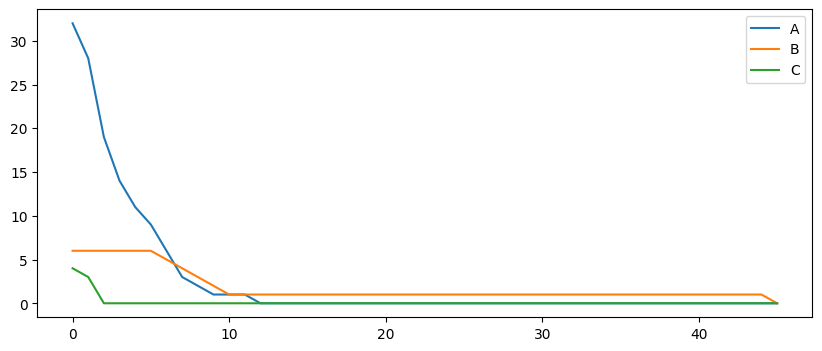

In [13]:
plt.figure(figsize=(10, 4))
# plot the different types
for agent_type, _ in sim.types:
    plt.plot(sim.get_summary()[agent_type], label=agent_type)

plt.legend()
plt.show()

In [14]:
sim.get_summary()

,cycle,agents,new_agents,A,B,C
0,0,42,2,32,6,4
1,1,37,0,28,6,3
2,2,25,0,19,6,0
3,3,20,2,14,6,0
4,4,17,0,11,6,0
5,5,15,0,9,6,0
6,6,11,0,6,5,0
7,7,7,0,3,4,0
8,8,5,0,2,3,0
9,9,3,0,1,2,0
